# Convolutional VAE For Face Generation

Used GPU (RTX 2060 Super) for training.

In [2]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib import animation
import random
import pickle
from tqdm import tqdm

from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Input
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Lambda
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Add, Multiply
import keras.backend as K

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import tensorflow._api.v2.compat.v1 as tf

tf.disable_v2_behavior()

### Methods Needed

In [3]:
def plot_images(rows, cols, images, title, size, save=False):
    grid = np.zeros(shape=(rows*H, cols*W, C))
    for row in range(rows):
        for col in range(cols):
            grid[row*H:(row+1)*H, col*W:(col+1)*W, :] = images[row*cols + col]

    plt.figure(figsize=(size[0], size[1]))       
    plt.imshow(grid)
    plt.title(title)
    plt.axis('off')
    plt.savefig(os.path.join('.\dump\img', f'{title}.png'))
    plt.show()

In [4]:
def plot_loss(history):
    # Create a figure and a set of subplots with 1 row and 3 columns
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Plot the first line chart
    axs[0].plot(list(range(EPOCHS)), history['loss'], color='red')
    axs[0].set_title('Loss')

    # Plot the second line chart
    axs[1].plot(list(range(EPOCHS)), history['reconstruction_loss'], color='blue')
    axs[1].set_title('Reconstruction Loss')

    # Plot the third line chart
    axs[2].plot(list(range(EPOCHS)), history['kl_loss'], color='orange')
    axs[2].set_title('KL Loss')

    # Add a title for the entire figure
    fig.suptitle('Loss Over Epochs', fontsize=16)

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

### Loading Data

In [5]:
PATH = r".\celebface_dataset"
H = 64
W = 64
C = 3
BATCH_SIZE = 512
SEED = 4040

In [6]:
x_data = []
load_image = 20000
list_image = os.listdir(PATH)
print(f"Totale number of images:> {len(list_image)}")
for e in tqdm(range(load_image)):
    image = Image.open(os.path.join(PATH, list_image[e]))
    image = image.resize((H, W))
    image = np.array(image)
    image = image / 255
    s = image.shape
    if len(s)!=3:
        continue
    else:
        if s[2]!=3:
            continue
    image = image.astype('float32')
    x_data.append(image)
    
train_data = np.asarray(x_data)
print('Dataset Successfully loaded!')
print(f'Shape:> {train_data.shape}')

Totale number of images:> 202599


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:16<00:00, 1186.95it/s]


Dataset Successfully loaded!
Shape:> (20000, 64, 64, 3)


Plot 25 random images:


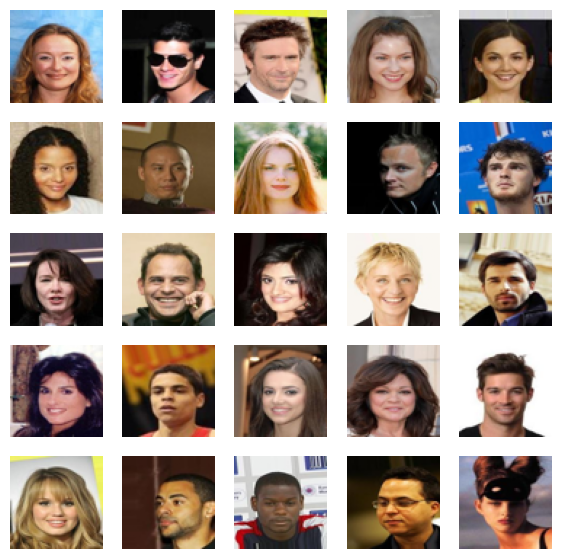

In [7]:
pic_to_show = 25
start = random.randint(0, train_data.shape[0]-pic_to_show-1)
imgs = train_data[start:start+pic_to_show, :, :]

print(f"Plot {pic_to_show} random images:")
plt.figure(figsize=(7, 7))
for i in range(imgs.shape[0]):
    img = imgs[i]
    ax = plt.subplot(int(np.sqrt(pic_to_show)), int(np.sqrt(pic_to_show)), i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()

__Encoder__

In [8]:
#NUMBER OF DIMENSIONS AFTER THE ENCODING PASS
latent_dims = 256

In [9]:
encoder_in = Input(shape=(H, W, C))   ##INPUT FOR THE IMAGE

encoder_l1 = Conv2D(filters=16, kernel_size=5, strides=2, padding='same')(encoder_in)
encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = Activation(LeakyReLU(0.2))(encoder_l1)

encoder_l1 = Conv2D(filters=16, kernel_size=5, strides=2, padding='same')(encoder_l1)
encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = Activation(LeakyReLU(0.2))(encoder_l1)


encoder_l2 = Conv2D(filters=32, kernel_size=5, strides=2, padding='same')(encoder_l1)
encoder_l2 = BatchNormalization()(encoder_l2)
encoder_l2 = Activation(LeakyReLU(0.2))(encoder_l2)

flatten = Flatten()(encoder_l2)

# extract of the dimension needen on decoder to parametrize on original image size
dimension_needed = flatten.get_shape().as_list()[1]
encoder_w = encoder_l2.get_shape().as_list()[1]
encoder_h = encoder_l2.get_shape().as_list()[2]
encoder_c = encoder_l2.get_shape().as_list()[3]

encoder_dense = Dense(latent_dims*2)(flatten)
encoder_dense = BatchNormalization()(encoder_dense)
encoder_out = Activation(LeakyReLU(0.2))(encoder_dense)


mu = Dense(latent_dims)(encoder_out)
log_var = Dense(latent_dims)(encoder_out)

batch = K.shape(mu)[0]
epsilon = K.random_normal(shape=(batch, latent_dims))

sigma = Lambda(lambda x: K.exp(0.5 * x))(log_var) # CHANGE log_var INTO STANDARD DEVIATION(sigma)
z_eps = Multiply()([sigma, epsilon])

z = Add()([mu, z_eps])

encoder = Model(encoder_in, z)
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   1216        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

__Decoder__

In [10]:
decoder_in = Input(shape=(latent_dims, ))  

decoder_l1 = Dense(latent_dims*2)(decoder_in)
decoder_l1 = BatchNormalization()(decoder_l1)
decoder_l1 = Activation(LeakyReLU(0.2))(decoder_l1)

decoder_l2 = Dense(dimension_needed)(decoder_l1)
decoder_l2 = BatchNormalization()(decoder_l2)
decoder_l2 = Activation(LeakyReLU(0.2))(decoder_l2)

decoder_reshape = Reshape(target_shape=(encoder_w, encoder_h, encoder_c))(decoder_l2)

decoder_l3 = Conv2DTranspose(filters=16, kernel_size=5, strides=2, padding='same')(decoder_reshape)
decoder_l3 = BatchNormalization()(decoder_l3)
decoder_l3 = Activation(LeakyReLU(0.2))(decoder_l3)

decoder_l4 = Conv2DTranspose(filters=16, kernel_size=5, strides=2, padding='same')(decoder_l3)
decoder_l4 = BatchNormalization()(decoder_l4)
decoder_l4 = Activation(LeakyReLU(0.2))(decoder_l4)

decoder_l5 = Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding='same')(decoder_l4)
decoder_l5 = BatchNormalization()(decoder_l5)
decoder_l5 = Activation(LeakyReLU(0.2))(decoder_l5)

decoder_l6 = Conv2DTranspose(filters=C, kernel_size=5, strides=1, padding='same')(decoder_l5)
decoder_l6 = BatchNormalization()(decoder_l6)
decoder_output = Activation('sigmoid')(decoder_l6)

decoder = Model(decoder_in, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 2048)              1050624   
                                                                 
 batch_normalization_5 (Batc  (None, 2048)             8192      
 hNormalization)                                           

__VAE__

In [11]:
def reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def kl_loss(y_true, y_pred):
    kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
    return kl_loss

def vae_loss(y_true, y_pred):
    return reconstruction_loss(y_true, y_pred) + 0.03 * kl_loss(y_true, y_pred)   #scaling kl_loss by 0.03 seem to help

In [12]:
adam = tf.keras.optimizers.Adam(learning_rate=.001)

vae_preds = decoder(z)
vae = Model(encoder_in, vae_preds)
vae.compile(optimizer=adam, loss=vae_loss , metrics=[reconstruction_loss, kl_loss])

In [13]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   1216        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization[0][0]

### Train

In [14]:
class ImageGenerationCallback(keras.callbacks.Callback): 
    def __init__(self):
        super().__init__()
    
    def on_epoch_end(self, epoch, logs=None):
        pic_to_show = 25
        start = random.randint(0, train_data.shape[0]-pic_to_show-1)
        imgs = train_data[start:start+pic_to_show, :, :]           
        if (epoch+1)%10==0 or epoch==0:
            print("End epoch {} of training; Image generation:".format(epoch+1))
            result = self.model.predict(imgs)
            plot_images(5, 5, result, f"Generated Images after {epoch+1} epochs", (5, 5), save=True)

Train on 20000 samples
Epoch 1/100
20000/20000 [==============================] - ETA: 0s - loss: 0.0649 - reconstruction_loss: 0.0579 - kl_loss: 0.2204End epoch 1 of training; Image generation:


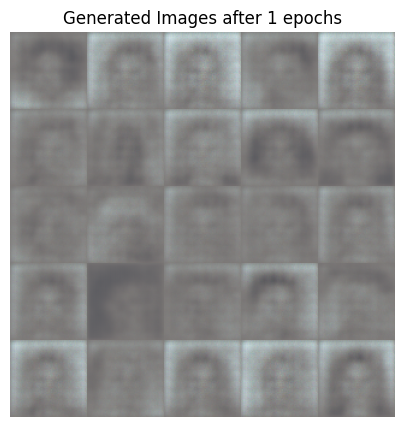

20000/20000 [==============================] - 8s 413us/sample - loss: 0.0649 - reconstruction_loss: 0.0579 - kl_loss: 0.2204
Epoch 2/100
20000/20000 [==============================] - 5s 239us/sample - loss: 0.0410 - reconstruction_loss: 0.0361 - kl_loss: 0.1637
Epoch 3/100
20000/20000 [==============================] - 5s 244us/sample - loss: 0.0371 - reconstruction_loss: 0.0320 - kl_loss: 0.1714
Epoch 4/100
20000/20000 [==============================] - 5s 242us/sample - loss: 0.0348 - reconstruction_loss: 0.0297 - kl_loss: 0.1752
Epoch 5/100
20000/20000 [==============================] - 5s 246us/sample - loss: 0.0331 - reconstruction_loss: 0.0277 - kl_loss: 0.1769
Epoch 6/100
20000/20000 [==============================] - 5s 246us/sample - loss: 0.0313 - reconstruction_loss: 0.0261 - kl_loss: 0.1739
Epoch 7/100
20000/20000 [==============================] - 5s 243us/sample - loss: 0.0295 - reconstruction_loss: 0.0244 - kl_loss: 0.1724
Epoch 8/100
20000/20000 [=====================

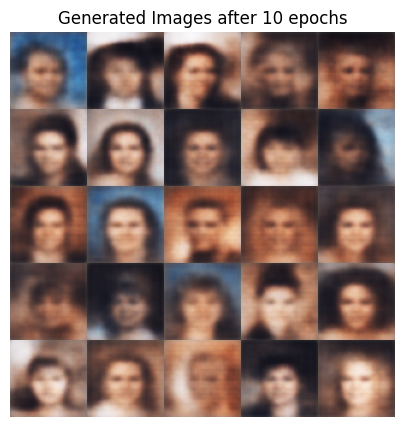

20000/20000 [==============================] - 5s 259us/sample - loss: 0.0261 - reconstruction_loss: 0.0211 - kl_loss: 0.1665
Epoch 11/100
20000/20000 [==============================] - 5s 241us/sample - loss: 0.0253 - reconstruction_loss: 0.0204 - kl_loss: 0.1659
Epoch 12/100
20000/20000 [==============================] - 5s 246us/sample - loss: 0.0247 - reconstruction_loss: 0.0198 - kl_loss: 0.1656
Epoch 13/100
20000/20000 [==============================] - 5s 246us/sample - loss: 0.0242 - reconstruction_loss: 0.0193 - kl_loss: 0.1648
Epoch 14/100
20000/20000 [==============================] - 5s 246us/sample - loss: 0.0238 - reconstruction_loss: 0.0188 - kl_loss: 0.1648
Epoch 15/100
20000/20000 [==============================] - 5s 239us/sample - loss: 0.0235 - reconstruction_loss: 0.0185 - kl_loss: 0.1656
Epoch 16/100
20000/20000 [==============================] - 5s 238us/sample - loss: 0.0231 - reconstruction_loss: 0.0182 - kl_loss: 0.1653
Epoch 17/100
20000/20000 [==============

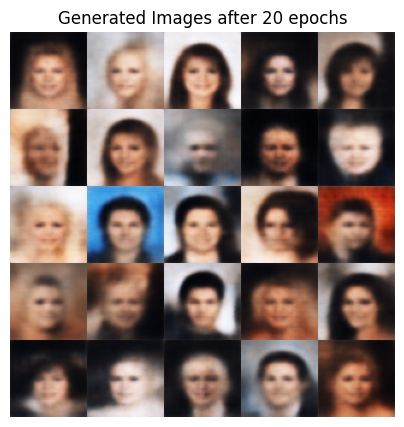

20000/20000 [==============================] - 5s 260us/sample - loss: 0.0222 - reconstruction_loss: 0.0173 - kl_loss: 0.1659
Epoch 21/100
20000/20000 [==============================] - 5s 241us/sample - loss: 0.0221 - reconstruction_loss: 0.0173 - kl_loss: 0.1669
Epoch 22/100
20000/20000 [==============================] - 5s 240us/sample - loss: 0.0220 - reconstruction_loss: 0.0170 - kl_loss: 0.1668
Epoch 23/100
20000/20000 [==============================] - 5s 236us/sample - loss: 0.0218 - reconstruction_loss: 0.0167 - kl_loss: 0.1676
Epoch 24/100
20000/20000 [==============================] - 5s 235us/sample - loss: 0.0217 - reconstruction_loss: 0.0167 - kl_loss: 0.1677
Epoch 25/100
20000/20000 [==============================] - 5s 236us/sample - loss: 0.0215 - reconstruction_loss: 0.0165 - kl_loss: 0.1683
Epoch 26/100
20000/20000 [==============================] - 5s 240us/sample - loss: 0.0215 - reconstruction_loss: 0.0165 - kl_loss: 0.1682
Epoch 27/100
20000/20000 [==============

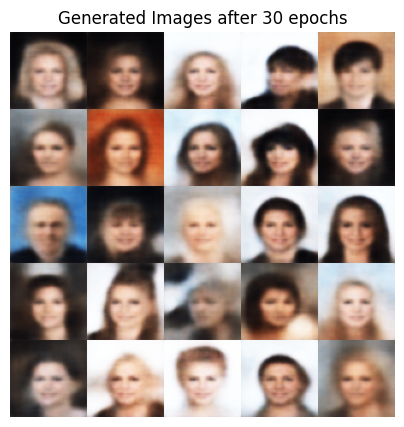

20000/20000 [==============================] - 5s 253us/sample - loss: 0.0211 - reconstruction_loss: 0.0161 - kl_loss: 0.1698
Epoch 31/100
20000/20000 [==============================] - 5s 243us/sample - loss: 0.0211 - reconstruction_loss: 0.0160 - kl_loss: 0.1696
Epoch 32/100
20000/20000 [==============================] - 5s 238us/sample - loss: 0.0210 - reconstruction_loss: 0.0159 - kl_loss: 0.1699
Epoch 33/100
20000/20000 [==============================] - 5s 241us/sample - loss: 0.0210 - reconstruction_loss: 0.0159 - kl_loss: 0.1702
Epoch 34/100
20000/20000 [==============================] - 5s 235us/sample - loss: 0.0209 - reconstruction_loss: 0.0158 - kl_loss: 0.1705
Epoch 35/100
20000/20000 [==============================] - 5s 236us/sample - loss: 0.0209 - reconstruction_loss: 0.0158 - kl_loss: 0.1714
Epoch 36/100
20000/20000 [==============================] - 5s 241us/sample - loss: 0.0208 - reconstruction_loss: 0.0158 - kl_loss: 0.1710
Epoch 37/100
20000/20000 [==============

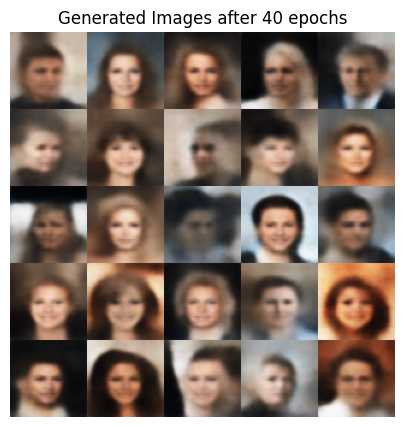

20000/20000 [==============================] - 5s 253us/sample - loss: 0.0207 - reconstruction_loss: 0.0156 - kl_loss: 0.1724
Epoch 41/100
20000/20000 [==============================] - 5s 234us/sample - loss: 0.0206 - reconstruction_loss: 0.0154 - kl_loss: 0.1720
Epoch 42/100
20000/20000 [==============================] - 5s 236us/sample - loss: 0.0206 - reconstruction_loss: 0.0155 - kl_loss: 0.1720
Epoch 43/100
20000/20000 [==============================] - 5s 237us/sample - loss: 0.0205 - reconstruction_loss: 0.0153 - kl_loss: 0.1725
Epoch 44/100
20000/20000 [==============================] - 5s 242us/sample - loss: 0.0205 - reconstruction_loss: 0.0154 - kl_loss: 0.1727
Epoch 45/100
20000/20000 [==============================] - 5s 241us/sample - loss: 0.0205 - reconstruction_loss: 0.0154 - kl_loss: 0.1727
Epoch 46/100
20000/20000 [==============================] - 5s 239us/sample - loss: 0.0204 - reconstruction_loss: 0.0153 - kl_loss: 0.1726
Epoch 47/100
20000/20000 [==============

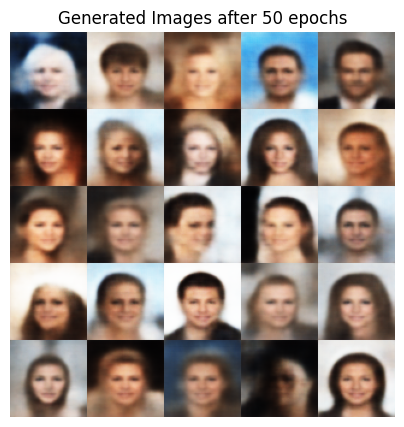

20000/20000 [==============================] - 5s 269us/sample - loss: 0.0204 - reconstruction_loss: 0.0152 - kl_loss: 0.1745
Epoch 51/100
20000/20000 [==============================] - 5s 238us/sample - loss: 0.0202 - reconstruction_loss: 0.0151 - kl_loss: 0.1742
Epoch 52/100
20000/20000 [==============================] - 5s 237us/sample - loss: 0.0202 - reconstruction_loss: 0.0151 - kl_loss: 0.1744
Epoch 53/100
20000/20000 [==============================] - 5s 237us/sample - loss: 0.0203 - reconstruction_loss: 0.0151 - kl_loss: 0.1747
Epoch 54/100
20000/20000 [==============================] - 5s 237us/sample - loss: 0.0202 - reconstruction_loss: 0.0150 - kl_loss: 0.1747
Epoch 55/100
20000/20000 [==============================] - 5s 237us/sample - loss: 0.0203 - reconstruction_loss: 0.0150 - kl_loss: 0.1753
Epoch 56/100
20000/20000 [==============================] - 5s 236us/sample - loss: 0.0202 - reconstruction_loss: 0.0151 - kl_loss: 0.1743
Epoch 57/100
20000/20000 [==============

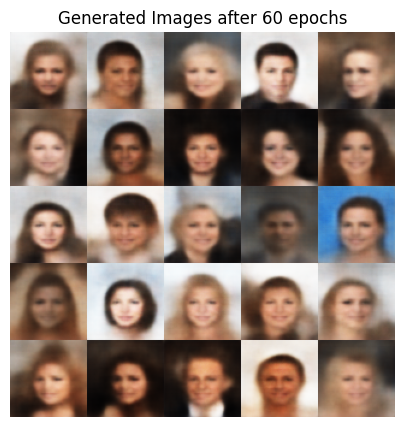

20000/20000 [==============================] - 5s 251us/sample - loss: 0.0200 - reconstruction_loss: 0.0148 - kl_loss: 0.1756
Epoch 61/100
20000/20000 [==============================] - 5s 240us/sample - loss: 0.0200 - reconstruction_loss: 0.0147 - kl_loss: 0.1760
Epoch 62/100
20000/20000 [==============================] - 5s 237us/sample - loss: 0.0200 - reconstruction_loss: 0.0148 - kl_loss: 0.1765
Epoch 63/100
20000/20000 [==============================] - 5s 246us/sample - loss: 0.0199 - reconstruction_loss: 0.0147 - kl_loss: 0.1753
Epoch 64/100
20000/20000 [==============================] - 5s 240us/sample - loss: 0.0200 - reconstruction_loss: 0.0147 - kl_loss: 0.1759
Epoch 65/100
20000/20000 [==============================] - 5s 237us/sample - loss: 0.0200 - reconstruction_loss: 0.0147 - kl_loss: 0.1764
Epoch 66/100
20000/20000 [==============================] - 5s 237us/sample - loss: 0.0199 - reconstruction_loss: 0.0147 - kl_loss: 0.1768
Epoch 67/100
20000/20000 [==============

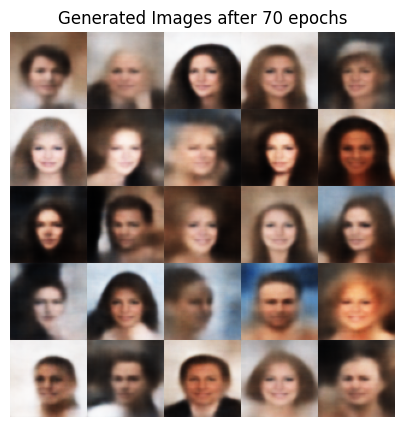

20000/20000 [==============================] - 5s 255us/sample - loss: 0.0198 - reconstruction_loss: 0.0146 - kl_loss: 0.1761
Epoch 71/100
20000/20000 [==============================] - 5s 242us/sample - loss: 0.0198 - reconstruction_loss: 0.0146 - kl_loss: 0.1770
Epoch 72/100
20000/20000 [==============================] - 5s 243us/sample - loss: 0.0198 - reconstruction_loss: 0.0146 - kl_loss: 0.1763
Epoch 73/100
20000/20000 [==============================] - 5s 239us/sample - loss: 0.0199 - reconstruction_loss: 0.0147 - kl_loss: 0.1771
Epoch 74/100
20000/20000 [==============================] - 5s 240us/sample - loss: 0.0198 - reconstruction_loss: 0.0145 - kl_loss: 0.1774
Epoch 75/100
20000/20000 [==============================] - 5s 237us/sample - loss: 0.0197 - reconstruction_loss: 0.0145 - kl_loss: 0.1770
Epoch 76/100
20000/20000 [==============================] - 5s 243us/sample - loss: 0.0197 - reconstruction_loss: 0.0145 - kl_loss: 0.1768
Epoch 77/100
20000/20000 [==============

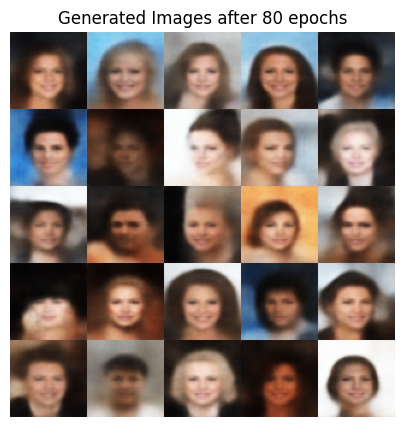

20000/20000 [==============================] - 5s 253us/sample - loss: 0.0197 - reconstruction_loss: 0.0145 - kl_loss: 0.1782
Epoch 81/100
20000/20000 [==============================] - 5s 238us/sample - loss: 0.0197 - reconstruction_loss: 0.0144 - kl_loss: 0.1767
Epoch 82/100
20000/20000 [==============================] - 5s 237us/sample - loss: 0.0196 - reconstruction_loss: 0.0145 - kl_loss: 0.1774
Epoch 83/100
20000/20000 [==============================] - 5s 242us/sample - loss: 0.0198 - reconstruction_loss: 0.0145 - kl_loss: 0.1778
Epoch 84/100
20000/20000 [==============================] - 5s 239us/sample - loss: 0.0196 - reconstruction_loss: 0.0144 - kl_loss: 0.1774
Epoch 85/100
20000/20000 [==============================] - 5s 238us/sample - loss: 0.0195 - reconstruction_loss: 0.0143 - kl_loss: 0.1773
Epoch 86/100
20000/20000 [==============================] - 5s 239us/sample - loss: 0.0196 - reconstruction_loss: 0.0144 - kl_loss: 0.1776
Epoch 87/100
20000/20000 [==============

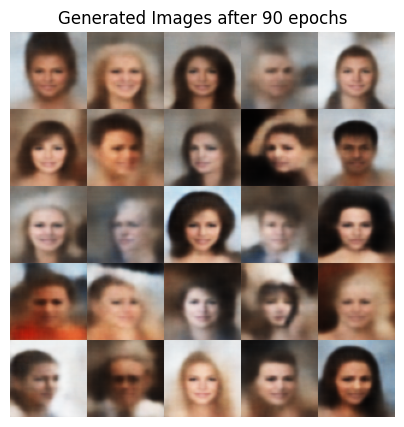

20000/20000 [==============================] - 5s 254us/sample - loss: 0.0196 - reconstruction_loss: 0.0143 - kl_loss: 0.1786
Epoch 91/100
20000/20000 [==============================] - 5s 239us/sample - loss: 0.0195 - reconstruction_loss: 0.0143 - kl_loss: 0.1783
Epoch 92/100
20000/20000 [==============================] - 5s 240us/sample - loss: 0.0196 - reconstruction_loss: 0.0143 - kl_loss: 0.1785
Epoch 93/100
20000/20000 [==============================] - 5s 239us/sample - loss: 0.0195 - reconstruction_loss: 0.0142 - kl_loss: 0.1781
Epoch 94/100
20000/20000 [==============================] - 5s 237us/sample - loss: 0.0194 - reconstruction_loss: 0.0142 - kl_loss: 0.1783
Epoch 95/100
20000/20000 [==============================] - 5s 240us/sample - loss: 0.0195 - reconstruction_loss: 0.0142 - kl_loss: 0.1780
Epoch 96/100
20000/20000 [==============================] - 5s 238us/sample - loss: 0.0195 - reconstruction_loss: 0.0143 - kl_loss: 0.1784
Epoch 97/100
20000/20000 [==============

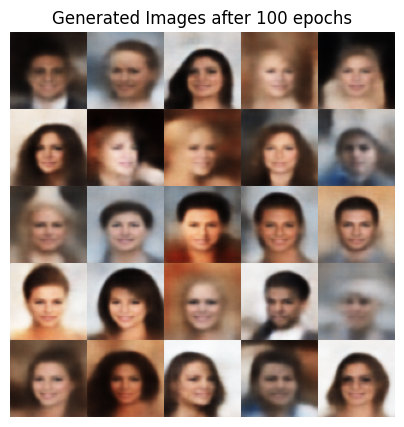

20000/20000 [==============================] - 5s 253us/sample - loss: 0.0194 - reconstruction_loss: 0.0141 - kl_loss: 0.1789


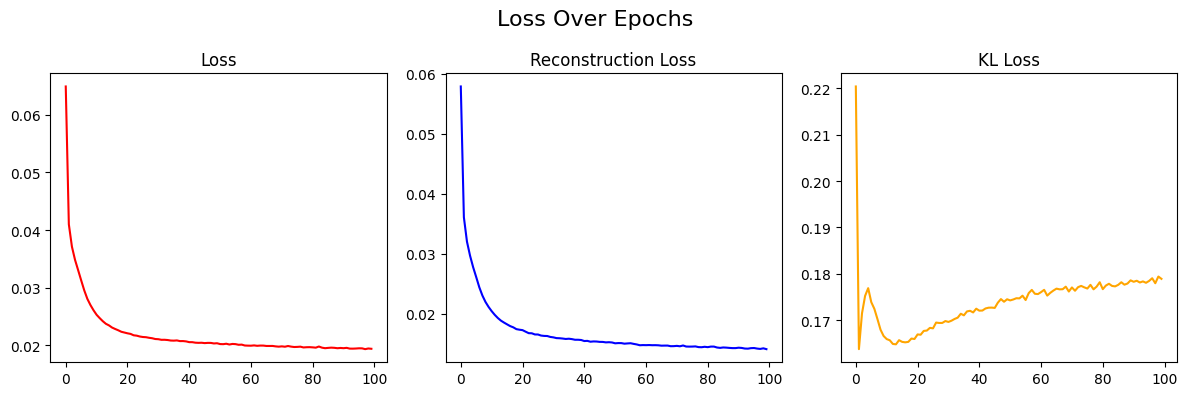

In [15]:
if os.path.exists(os.path.join(r'.\dump\model\hd.pkl')):
    decoder.load_weights(r'.\dump\model\decoder.h5')
    encoder.load_weights(r'.\dump\model\encoder.h5')
    vae.load_weights(r'.\dump\model\vae.h5')
    with open(os.path.join(r'.\dump\model', 'hd.pkl'), 'rb') as file:
        history = pickle.load(file)
    
    print('Model correctly loaded from disk!') 
else:
    EPOCHS = 100

    hd = vae.fit(train_data, train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[ImageGenerationCallback()])
    history = hd.history
    
    decoder.save_weights(r'.\dump\model\decoder.h5')
    encoder.save_weights(r'.\dump\model\encoder.h5')
    vae.save_weights(r'.\dump\model\vae.h5')
    with open(os.path.join(r'.\dump\model', 'hd.pkl'), 'wb') as file:
        pickle.dump(history, file)
    
plot_loss(history)

### Predict New Images From Latent Space

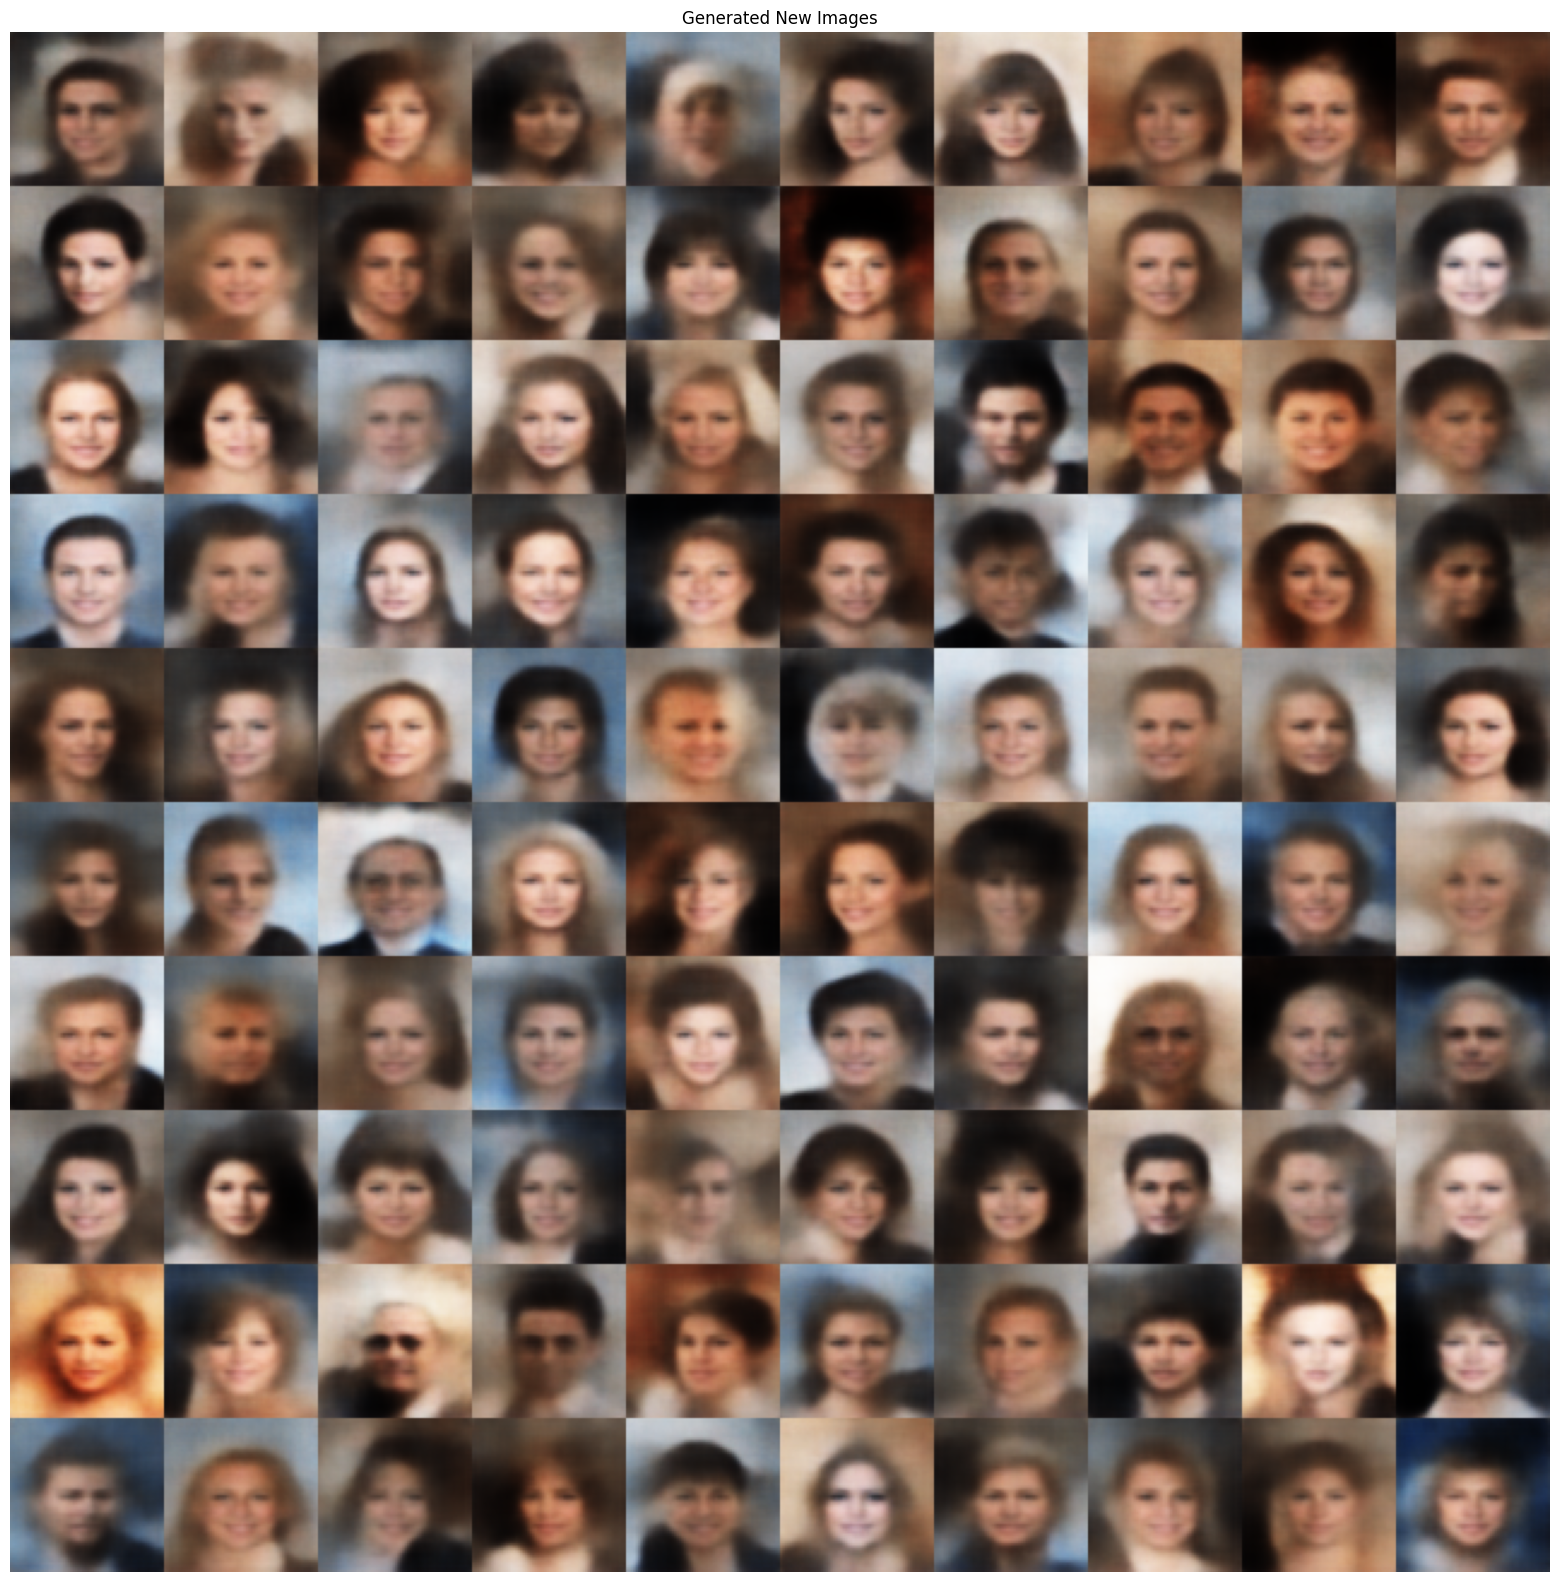

In [16]:
predictions= decoder.predict(np.random.randn(100, latent_dims))
plot_images(10, 10, predictions, "Generated New Images", (20, 20), save=True)